In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.offsetbox import AnchoredText
import arviz as az

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Typo - page 271 - not really a typo, but the idea of 6 shells and 4 stones doesn't really make sense, because the difference should always be 1 given the parameters of island size
# Typo - page 275 - 'it moves SLOW (slowly)'
# Typo - page 278 - 'Hamilton ACCOMPISH (accomplished)'
# Typo - page 280 - 'A no-U-turn sampler GUESS FROM (guesses?) the shape of the posterior...'
# Typo - page 290 - trace plots do not reflect current model (they're based on an interaction model from version 1 of the text, I think)
# Typo - page 291 - 'A second way to visualize the chains is much CLEAR (clearer)'
# Typo - page 292 (in figure 9.9) - '..these histograms should be REASONABLE (reasonably) uniform...'
# Typo - page 294 - end of paragraph 1, "This" followed by nothing.


In [2]:
# R code 9.1

number_weeks = int(1e5)
positions = np.zeros(number_weeks)
current = 10

for i in range(0,number_weeks):
    positions[i] = current
    proposal = current + np.random.random_integers(-1,1)
    if proposal < 1:
        proposal = 10
    elif proposal > 10:
        proposal = 1
    
    prob_move = proposal/current
    if np.random.uniform() < prob_move:
        current = proposal   

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-1, 1 + 1) instead
  if __name__ == '__main__':


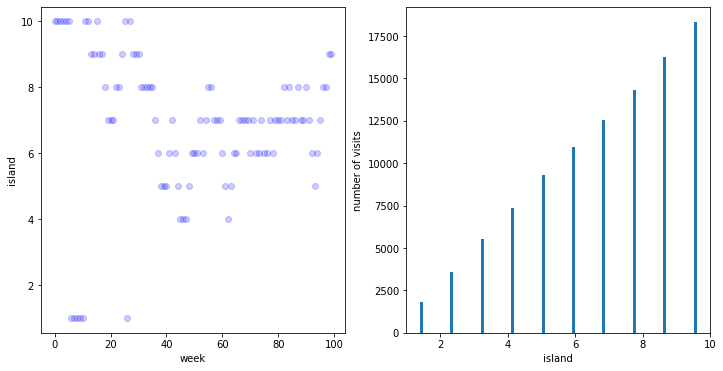

In [3]:
# Reproducing figure 9.2

f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
for i in range(0,100):
    ax1.plot(i, positions[i], 'ob', alpha = 0.2)
ax1.set_xlabel("week")
ax1.set_ylabel("island")

ax2 = f.add_subplot(122)
ax2.hist(positions, 10, rwidth = 0.1)
ax2.set_xlabel("island")
ax2.set_ylabel("number of visits");

In [4]:
# R code 9.11, 9.12
# All copied from different parts of chapter 8

d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
d['log_gdp']=np.log(d['rgdppc_2000'])
dd = d.drop(d[d['rgdppc_2000'].isnull()].index)
dd['log_gdp_std']=dd['log_gdp']/dd['log_gdp'].mean()
dd['rugged_std']=dd['rugged']/dd['rugged'].max()
d_A1 = dd[dd['cont_africa']==1]
d_A0 = dd[dd['cont_africa']==0]

cid = pd.Categorical(dd['cont_africa'])
dd['cid']=cid.codes

with pm.Model() as m_9_1:
    alpha = pm.Normal('alpha', mu=1, sd=0.1, shape=2) 
    beta = pm.Normal('beta', mu=0, sd=0.3, shape=2) 
    mu = alpha[(cid)]+ beta[(cid)]* (dd.rugged_std - dd['rugged_std'].mean())
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=dd.log_gdp_std)
    trace_9_1= pm.sample(5000, tune=1000, chains=2)


C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████████████████████

In [5]:
pm.summary(trace_9_1, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha__0,1.05,0.01,0.0,1.03,1.07,15293.48,1.0
alpha__1,0.89,0.02,0.0,0.86,0.91,13660.17,1.0
beta__0,-0.14,0.06,0.0,-0.23,-0.05,13793.03,1.0
beta__1,0.13,0.08,0.0,0.01,0.25,13607.33,1.0
sigma,0.11,0.01,0.0,0.10,0.12,14457.43,1.0


In [6]:
trace_9_1['alpha'].shape

(10000, 2)

In [7]:
# R code 9.14
with pm.Model() as m_9_1:
    alpha = pm.Normal('alpha', mu=1, sd=0.1, shape=2) 
    beta = pm.Normal('beta', mu=0, sd=0.3, shape=2) 
    mu = alpha[(cid)]+ beta[(cid)]* (dd.rugged_std - dd['rugged_std'].mean())
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=dd.log_gdp_std)
    trace_9_1= pm.sample(1000, tune=1000, chains=4, cores=4)

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1588.40draws/s]


In [8]:
with  m_9_1:
    trace_9_1_x = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1597.89draws/s]


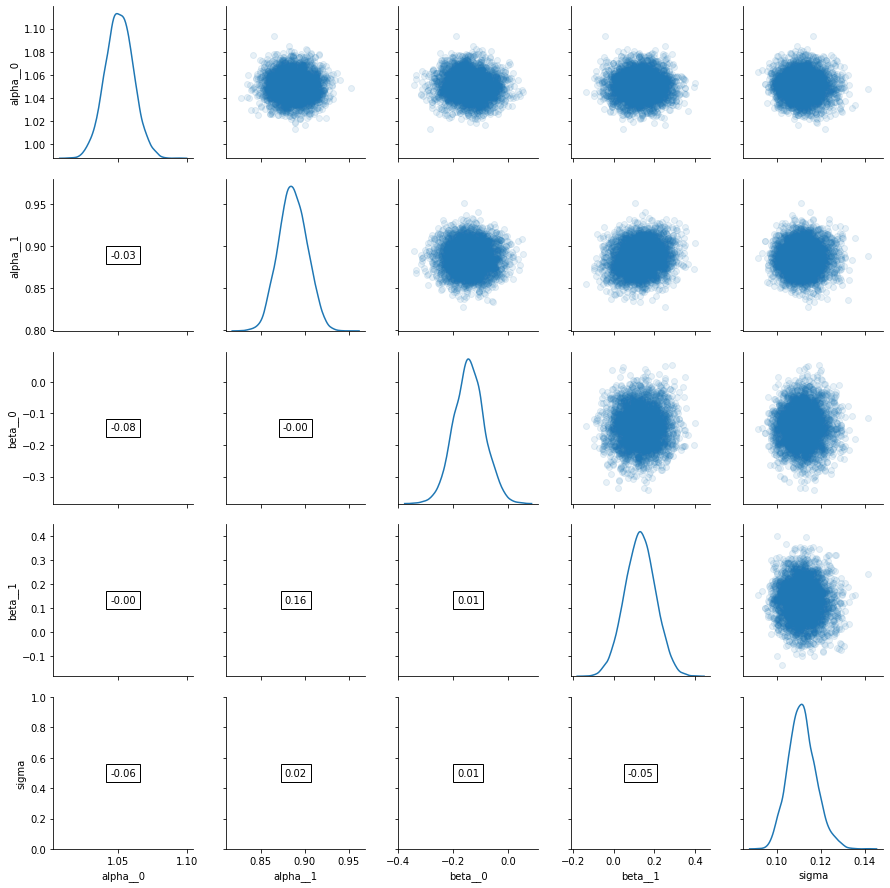

In [9]:
trace_9_1_df = pm.trace_to_dataframe(trace_9_1)
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

trace_9_1_df = pm.trace_to_dataframe(trace_9_1)
grid = (sns.PairGrid(trace_9_1_df,
                     x_vars=['alpha__0', 'alpha__1', 'beta__0', 'beta__1', 'sigma'],
                     y_vars=['alpha__0', 'alpha__1', 'beta__0', 'beta__1', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


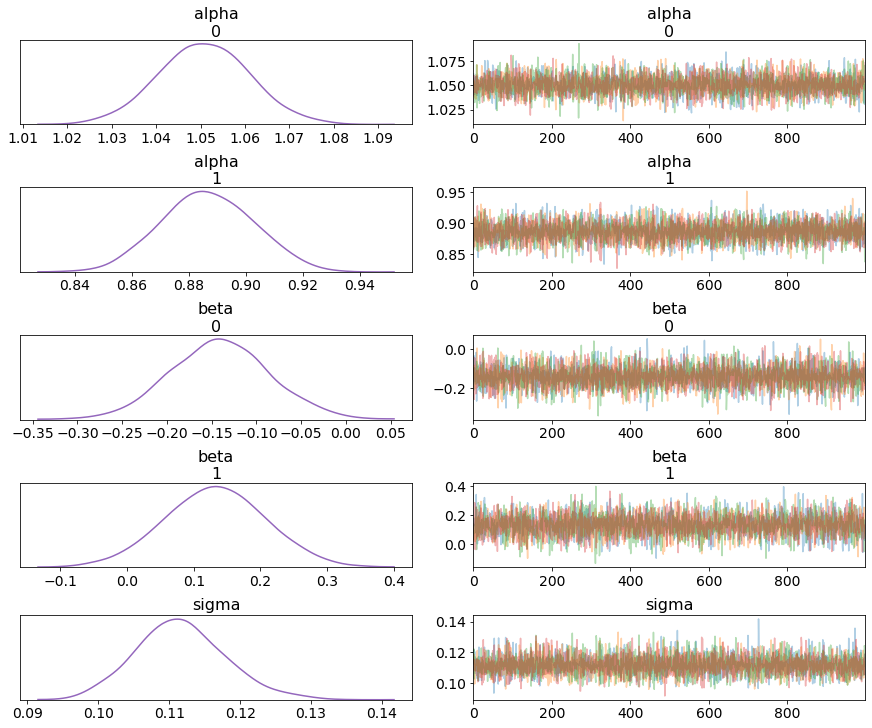

In [10]:
# R code 9.18

az.plot_trace(trace_9_1, combined=True);

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


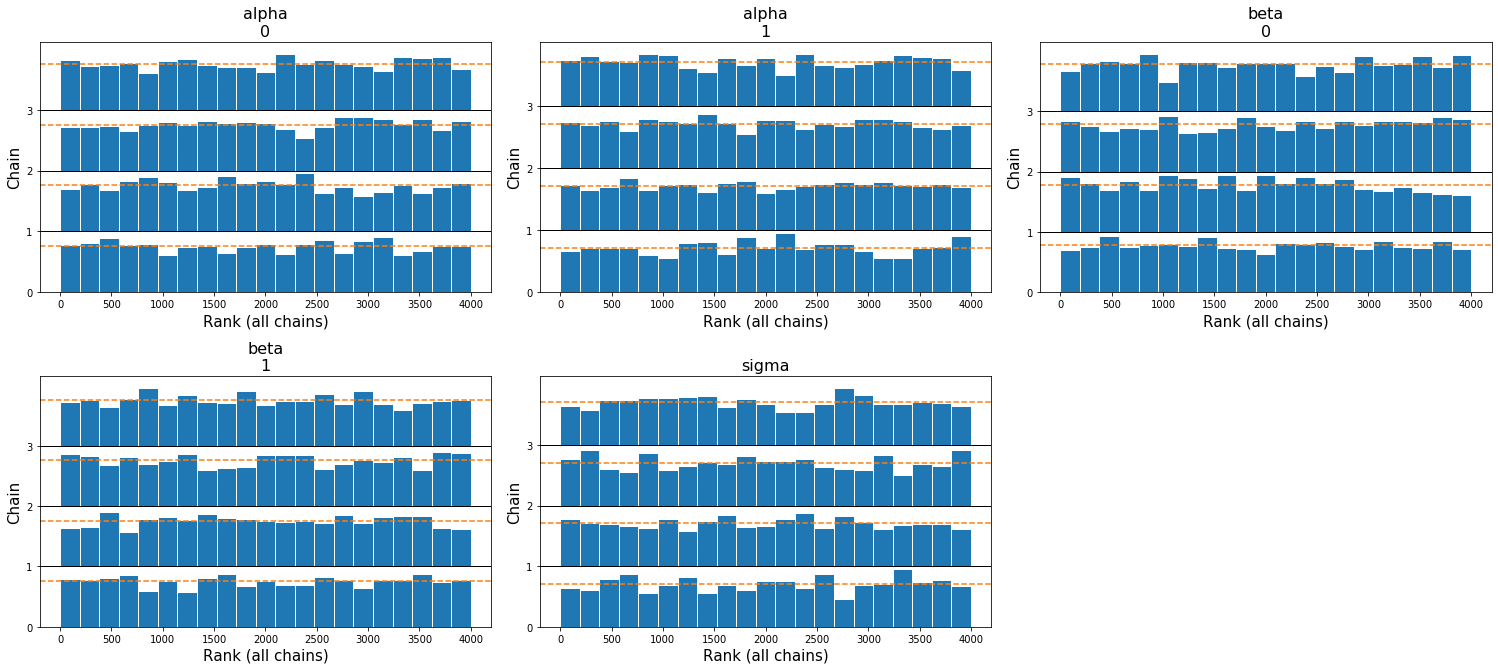

In [11]:
az.plot_rank(trace_9_1);

In [12]:
# R code 9.20

y = [-1,1]
with pm.Model() as m_9_2:
    alpha = pm.Normal('alpha', mu=0, sd=1000) 
    mu = alpha
    sigma = pm.Exponential('sigma', 0.0001)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    trace_9_2= pm.sample(1000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1146.57draws/s]
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6534718289765323, but should be close to 0.8. Try to increase the number of tuning steps.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6265961692248062, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
# R code 9.21

pm.summary(trace_9_2, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-19.18,398.80,22.67,-553.52,608.92,210.19,1.02
sigma,673.36,1530.27,82.93,7.75,1657.02,218.71,1.00


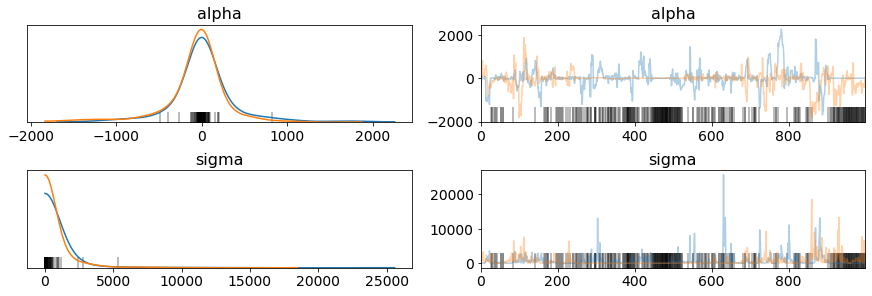

In [14]:
# Figure 9.10 (top)

az.plot_trace(trace_9_2);

In [17]:
# R code 9.22

y = [-1,1]
with pm.Model() as m_9_3:
    alpha = pm.Normal('alpha', mu=0, sd=10) 
    mu = alpha
    sigma = pm.HalfCauchy('sigma', 1.)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    trace_9_3= pm.sample(1000, tune=1000, chains=2, cores=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1341.70draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6952884997671548, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
pm.summary(trace_9_3, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.13,1.79,0.08,-2.05,2.35,450.19,1.0
sigma,2.13,2.26,0.10,0.51,3.61,399.52,1.0


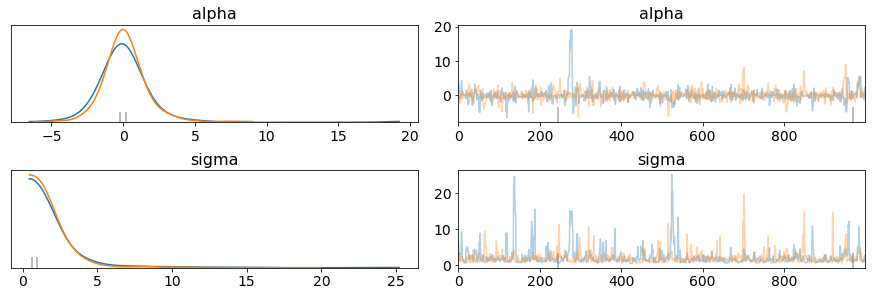

In [19]:
# Figure 9.10 (bottom)

az.plot_trace(trace_9_3);

In [25]:
# R code 9.23

yvals = stats.norm.rvs(loc=0, scale=1, size = 100)

In [22]:
# R code 9.24
with pm.Model() as m_9_4:
    a1 = pm.Normal('a1', mu=0, sd=1000) 
    a2 = pm.Normal('a2', mu=0, sd=1000)
    mu = a1 + a2
    sigma = pm.Exponential('sigma', 1.)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=yvals)
    trace_9_4= pm.sample(1000, tune=1000, chains=2, cores=2)
    
pm.summary(trace_9_4, alpha = 0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 4000/4000 [01:54<00:00, 15.19draws/s]
The acceptance probability does not match the target. It is 0.8879284310514304, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8848267578798352, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,172.69,428.87,42.37,-415.19,868.56,2.19,1.58
a2,-172.80,428.88,42.37,-868.56,415.06,2.19,1.58
sigma,1.11,0.07,0.01,0.99,1.22,69.91,1.00


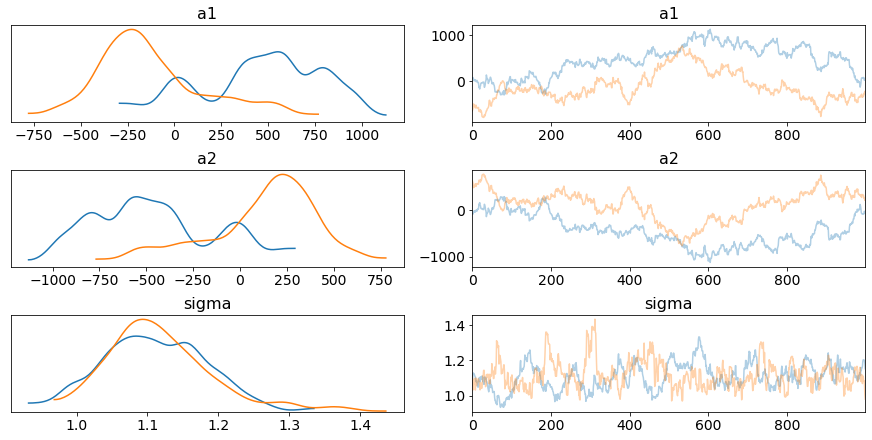

In [23]:
# Figure 9.12 (left)

az.plot_trace(trace_9_4);

# Terrible! All because of the priors.

In [26]:
# R code 9.25

with pm.Model() as m_9_5:
    a1 = pm.Normal('a1', mu=0, sd=10) 
    a2 = pm.Normal('a2', mu=0, sd=10)
    mu = a1 + a2
    sigma = pm.Exponential('sigma', 1.)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=yvals)
    trace_9_5= pm.sample(1000, tune=1000, chains=2, cores=2)
    
pm.summary(trace_9_5, alpha = 0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:26<00:00, 153.81draws/s]
The acceptance probability does not match the target. It is 0.8869331568688779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870984430400755, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,0.24,6.62,0.23,-11.02,10.09,742.26,1.0
a2,-0.28,6.62,0.23,-9.63,11.44,742.36,1.0
sigma,1.11,0.08,0.00,0.98,1.24,786.20,1.0


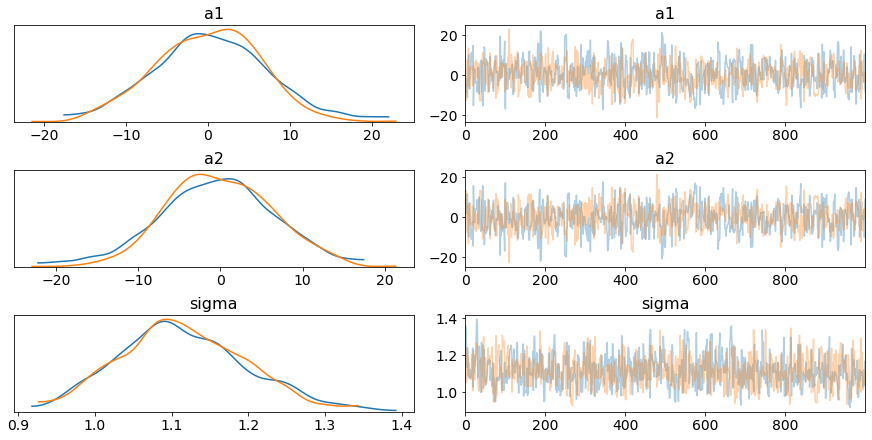

In [27]:
# Figure 9.12 (right)

az.plot_trace(trace_9_5);

# Better! Even though the priors are only very weakly informative.